In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.patches as patches
import talib

# Load the MT5 CSV
df = pd.read_csv( "xauusdm15.filtered.csv" )

# Set DateTime as index
df['DateTime'] = pd.to_datetime(df["DateTime"])
df.set_index("DateTime", inplace=True)

# Optional: keep only OHLC + Volume for plotting
ohlc_df = df[["Open", "High", "Low", "Close", "Volume"]]


In [2]:
def detect_macd_cross(df, macd_col='MACD', signal_col='MACD_Signal'):
    """
    Detects MACD crossovers in a DataFrame.

    Parameters:
    - df: DataFrame containing MACD and Signal columns
    - macd_col: name of the MACD column
    - signal_col: name of the Signal column

    Returns:
    - A Series with 1 (buy), -1 (sell), 0 (no crossover)
    """
    cross = pd.Series(0, index=df.index)

    # Buy signal: MACD crosses above Signal
    buy_mask = (df[macd_col].shift(1) < df[signal_col].shift(1)) & (df[macd_col] > df[signal_col])
    cross[buy_mask] = 1

    # Sell signal: MACD crosses below Signal
    sell_mask = (df[macd_col].shift(1) > df[signal_col].shift(1)) & (df[macd_col] < df[signal_col])
    cross[sell_mask] = -1

    return cross


In [3]:
macd_line, signal_line, macd_hist = talib.MACD(
    ohlc_df['Close'],
    fastperiod=12,
    slowperiod=26,
    signalperiod=9
)

ohlc_df['MACD'] = macd_line
ohlc_df['MACD_Signal'] = signal_line
ohlc_df['MACD_Hist'] = macd_hist

# Detect MACD crossover
ohlc_df['Crossover'] = detect_macd_cross(ohlc_df)

# Add SL and TP columns
ohlc_df['SL'] = np.nan
ohlc_df['TP'] = np.nan


# Bullish crossover: SL = previous candle low, TP = Close + 20
ohlc_df.loc[ohlc_df['Crossover'] == 1, 'SL'] = ohlc_df['Low'].shift(1)
ohlc_df.loc[ohlc_df['Crossover'] == 1, 'TP'] = ohlc_df['Close'] + 5

# Optional: bearish crossover
# ohlc_df.loc[ohlc_df['Crossover'] == -1, 'SL'] = ohlc_df['High'].shift(1)
# ohlc_df.loc[ohlc_df['Crossover'] == -1, 'TP'] = ohlc_df['Close'] - 20

# Filter bullish crossovers
cross_rows = ohlc_df[ohlc_df['Crossover'] == 1]

# Display
cross_rows[['MACD', 'MACD_Signal', 'MACD_Hist', 'Crossover', 'SL', 'TP']].tail()


,MACD,MACD_Signal,MACD_Hist,Crossover,SL,TP
DateTime,,,,,,
2024-12-30 03:15:00,1.468397,1.364303,0.104094,1,2623.138,2632.077
2024-12-30 11:15:00,-2.053279,-2.233354,0.180075,1,2609.092,2620.989
2024-12-30 17:45:00,-3.429495,-3.742780,0.313285,1,2601.374,2610.141
2024-12-31 06:30:00,-0.229771,-0.234759,0.004988,1,2604.427,2611.494
2024-12-31 14:00:00,0.443144,0.395193,0.047950,1,2611.272,2618.457


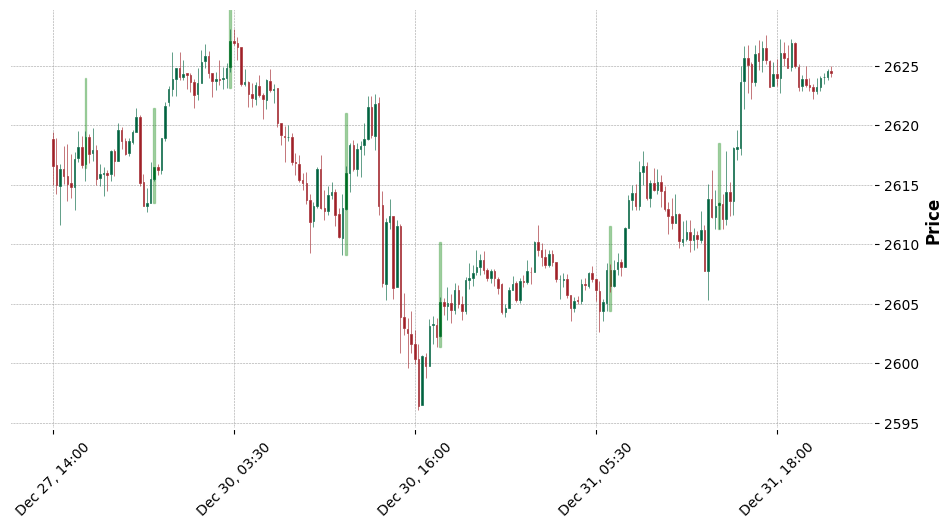

In [4]:
# Slice data
dta = ohlc_df.iloc[23300:].copy()
dta = dta.reset_index()  # reset index so integer indices match x-axis

# Plot candlestick chart and get axes
fig, axlist = mpf.plot(
    dta.set_index('DateTime'),  # mplfinance still needs datetime index
    type='candle',
    style='charles',
    returnfig=True,
    figsize=(12,6)
)
ax = axlist[0]  # main price axis

# Draw boxes for bullish crossovers
for i, row in dta.iterrows():
    if row['Crossover'] == 1 and not pd.isna(row['SL']) and not pd.isna(row['TP']):
        width = 0.5  # width of the box in candle units
        # Use integer index for x
        rect = patches.Rectangle(
            (i - width/2, row['SL']),
            width,
            row['TP'] - row['SL'],
            color='green',
            alpha=0.3
        )
        ax.add_patch(rect)

mpf.show()


In [5]:
ohlc_df.to_csv("applyiedMacd-1.csv", index=True)

In [6]:
def plot_candles(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    addplots = []

    # Only add EMA if it exists
    # addplots.append(mpf.make_addplot(df['EMA_51'], color='orange', width=1.2))

    addplots.append(mpf.make_addplot(df['MACD'], panel=1, color='green', width=1.2))
    addplots.append(mpf.make_addplot(df['MACD_Signal'], panel=1, color='red', width=1.2))

    charttype = "candle"
    title = f"{charttype.capitalize()} - Chart"

    fig, axes = mpf.plot(
        df,
        type=charttype,
        style='classic',
        volume=False,
        figratio=(14, 7),
        figscale=1.2,
        returnfig=True,
        addplot=addplots,
        title=title,
        block=False
    )
    return fig, axes


In [7]:
def vertical_lines_on(axes, df, panel_idx=1, flag_col='isBear', color='red', linewidth=2):

    # Handle both list of axes or single axes
    ax = axes[panel_idx] if isinstance(axes, (list, tuple)) else axes

    ylim = ax.get_ylim()
    for i, flag in enumerate(df[flag_col]):
        if flag == 1:
            ax.vlines(i, ylim[0], ylim[1], color=color, linewidth=linewidth)
    ax.figure.canvas.draw()


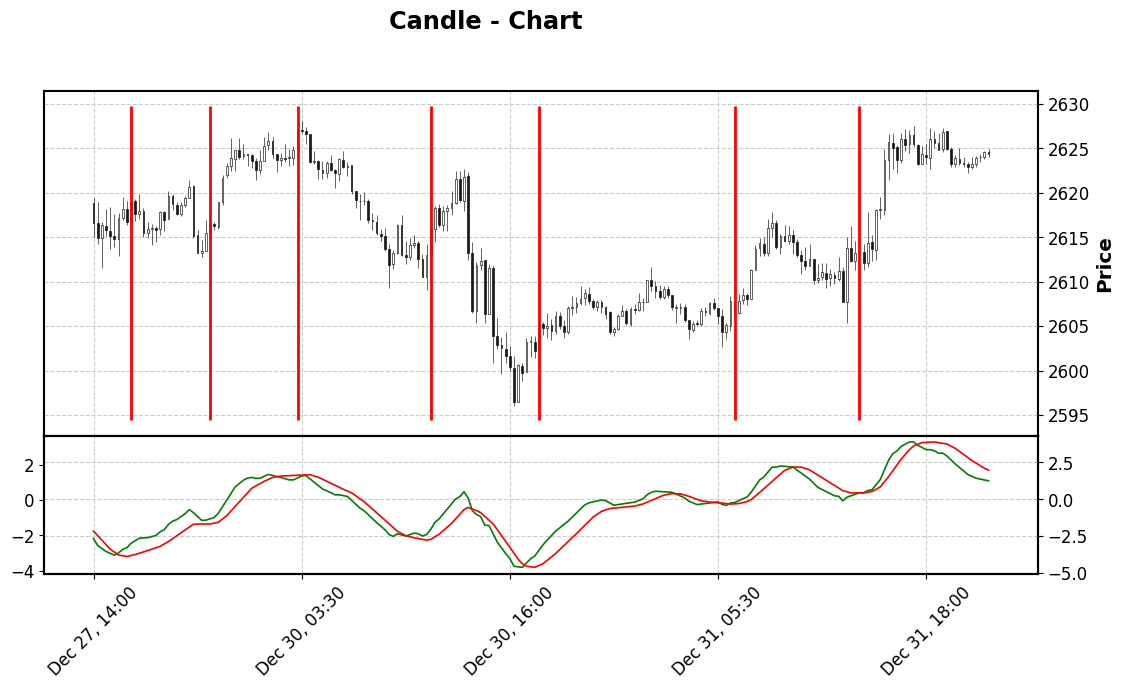

In [8]:
dta = ohlc_df.iloc[23300:];

fig, axis = plot_candles(dta);
vertical_lines_on(axis, dta, 0, "Crossover")